In [6]:
cd ..

/home/dmitriishubin/Desktop/Projects/mask/head_pose


In [380]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import json
import pickle

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.svm import SVR
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [384]:
DATA_PATH = './data/processed/'

df = pd.read_csv(DATA_PATH+'data.csv')
df = df.dropna()
df = df[df.upper_sides_proportion< 1.75]
#df = df[df.vertical_sides_proportion< 2]
df.head(10)

,upper_sides_proportion,vertical_sides_proportion,alpha,beta,gamma,person_id,theta_x,theta_y,theta_z
0,0.990156,0.414859,40.109598,40.591160,99.299242,1,-7.705271,3.053093,-1.991137
1,0.975714,0.452508,41.561740,42.838921,95.599339,1,-7.792844,3.595073,-2.435243
2,0.975714,0.452508,41.561740,42.838921,95.599339,1,-7.578725,3.379035,-2.408475
3,0.978068,0.471363,42.762374,43.962223,93.275403,1,-7.591798,3.515111,-2.377601
4,0.978068,0.471363,42.762374,43.962223,93.275403,1,-7.863294,3.113472,-2.569418
5,0.978068,0.471363,42.762374,43.962223,93.275403,1,-7.699312,3.733324,-2.758288
6,0.978068,0.471363,42.762374,43.962223,93.275403,1,-7.678917,3.344098,-2.301312
7,0.978068,0.471363,42.762374,43.962223,93.275403,1,-7.832590,3.457985,-2.666504
8,0.978068,0.471363,42.762374,43.962223,93.275403,1,-7.625574,3.275614,-2.646087
9,0.978068,0.471363,42.762374,43.962223,93.275403,1,-7.724696,3.497265,-2.444372


# Explore target 

<Figure size 720x720 with 0 Axes>

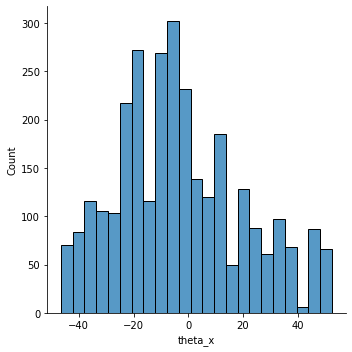

<Figure size 720x720 with 0 Axes>

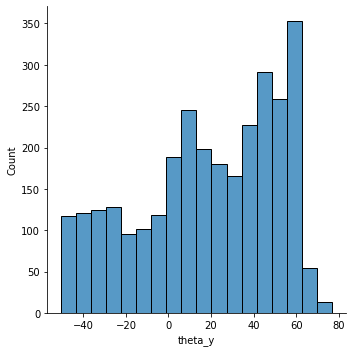

<Figure size 720x720 with 0 Axes>

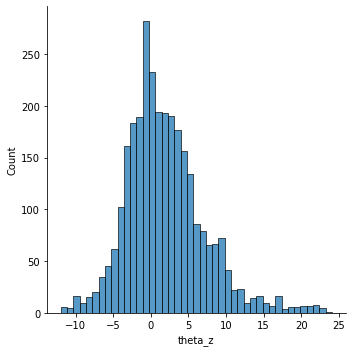

In [385]:
fig = plt.figure(figsize=(10,10))
sns.displot(df['theta_x'])

fig = plt.figure(figsize=(10,10))
sns.displot(df['theta_y'])

fig = plt.figure(figsize=(10,10))
sns.displot(df['theta_z'])

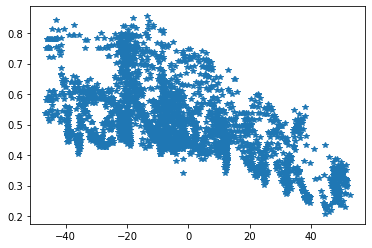

In [386]:
plt.plot(df.theta_x,df.vertical_sides_proportion,'*')

# Theta Y model

In [329]:
df.head()

,upper_sides_proportion,vertical_sides_proportion,alpha,beta,gamma,person_id,theta_x,theta_y,theta_z
0,0.995420,1.141564,41.521757,41.755601,96.722642,1,-7.705271,3.053093,-1.991137
1,0.978068,1.189129,42.762374,43.962223,93.275403,1,-7.792844,3.595073,-2.435243
2,0.975714,1.141564,41.561740,42.838921,95.599339,1,-7.578725,3.379035,-2.408475
3,0.978068,1.189129,42.762374,43.962223,93.275403,1,-7.591798,3.515111,-2.377601
4,0.978068,1.189129,42.762374,43.962223,93.275403,1,-7.863294,3.113472,-2.569418


In [330]:
model = LinearRegression()
#model = SVR(kernel='linear',degree=1,C=10)
#model = Ridge()

kf = GroupKFold(n_splits=3)

X = df['upper_sides_proportion'].values
y = df['theta_y'].values
groups = df['person_id'].values

for (index_train,index_val) in kf.split(X, y, groups):
    X_train,X_val = X[index_train],X[index_val]
    
    y_train,y_val = y[index_train],y[index_val]
    group_train,group_val = groups[index_train],groups[index_val]
    
    model.fit(X=X_train.reshape(-1,1),y=y_train)
    
    preds = model.predict(X_val.reshape(-1,1))
    
    print(f'Person_id, train: {np.unique(group_train)}')
    print(f'Person_id, val: {np.unique(group_val)}')
    
    print(f'MAE: {mae(y_true=y_val,y_pred=preds)}')
    print(f'MSE: {mse(y_true=y_val,y_pred=preds)}')
    
    

Person_id, train: [1 2 3 4]
Person_id, val: [5]
MAE: 11.871913148970647
MSE: 205.0810105683071
Person_id, train: [2 3 5]
Person_id, val: [1 4]
MAE: 15.24978219054233
MSE: 395.14520701366837
Person_id, train: [1 4 5]
Person_id, val: [2 3]
MAE: 14.96869483018592
MSE: 332.2737205761722


In [331]:
#X_ideal = np.array([1.7,1,0.3])
X_ideal = np.array([1.5,1,0.5])
y_ideal = np.array([-40,0, 40])

model.fit(X=X_ideal.reshape(-1,1),y=y_ideal)

LinearRegression()

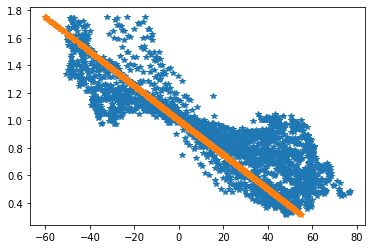

In [332]:
probbing = model.predict(df.upper_sides_proportion.values.reshape(-1,1))

plt.plot(df.theta_y,df.upper_sides_proportion,'*')
plt.plot(probbing,df.upper_sides_proportion,'*')

In [333]:
pickle.dump(model, open('../data/linear_model_theta_y.pkl', 'wb'))

# Theta X model

In [403]:
model = LinearRegression()
#model = SVR(kernel='linear',degree=1,C=10)
#model = Ridge()
#DotProduct, WhiteKernel
#model = GaussianProcessRegressor(kernel=WhiteKernel())

kf = GroupKFold(n_splits=3)

X = df.vertical_sides_proportion.values
y = df['theta_x'].values
groups = df['person_id'].values

for (index_train,index_val) in kf.split(X, y, groups):
    X_train,X_val = X[index_train],X[index_val]
    
    y_train,y_val = y[index_train],y[index_val]
    group_train,group_val = groups[index_train],groups[index_val]
    
    model.fit(X=X_train.reshape(-1,1),y=y_train)
    
    preds = model.predict(X_val.reshape(-1,1))
    
    print(f'Person_id, train: {np.unique(group_train)}')
    print(f'Person_id, val: {np.unique(group_val)}')
    
    print(f'MAE: {mae(y_true=y_val,y_pred=preds)}')
    print(f'MSE: {mse(y_true=y_val,y_pred=preds)}')

Person_id, train: [1 2 3 4]
Person_id, val: [5]
MAE: 10.070412230986378
MSE: 152.07108471225192
Person_id, train: [2 3 5]
Person_id, val: [1 4]
MAE: 16.28941751208072
MSE: 383.87331968289897
Person_id, train: [1 4 5]
Person_id, val: [2 3]
MAE: 17.574688636835518
MSE: 441.2869556849316


In [443]:
#X_ideal = np.array([1.7,1,0.3])
X_ideal = np.array([0.6,0.4,0.2])
y_ideal = np.array([-70,0, 60])

model.fit(X=X_ideal.reshape(-1,1),y=y_ideal)

LinearRegression()

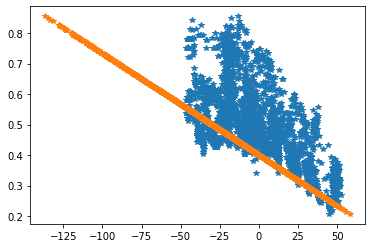

In [444]:
probbing = model.predict(df[['vertical_sides_proportion']].values)

plt.plot(df.theta_x,df.vertical_sides_proportion,'*')
plt.plot(probbing,df.vertical_sides_proportion,'*')


In [445]:
probbing

array([ -4.45765952, -15.75243564, -15.75243564, ..., -10.58809506,
       -15.99248591, -10.82336985])

In [446]:
pickle.dump(model, open('../data/linear_model_theta_x.pkl', 'wb'))